In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools 
import scipy
import matplotlib
import glob
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scipy.io as sio
import matplotlib.mlab as mlab

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.io as io

In [2]:
local_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 'chr_idx', 
                    'region', 'distance', 'num_cell', 'bin', 'pval', 'fc', 
                    'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [3]:
MB361_local_hits = pd.read_csv('./MB361-filter_local_df.csv')[local_df_columns]
MB231_local_hits = pd.read_csv('./MB231-filter_local_df.csv')[local_df_columns]

In [4]:
common_local_region = set(MB361_local_hits['region']).intersection(set(MB231_local_hits['region']))

In [5]:
len(common_local_region)

57

In [6]:
common_local_hits = set(MB361_local_hits['gene_names']).intersection(set(MB231_local_hits['gene_names']))

In [7]:
len(common_local_hits)

55

In [8]:
print(MB361_local_hits.shape)
print(MB231_local_hits.shape)

(366, 15)
(335, 15)


## Scatter plots 
___

In [9]:
MB361_local_pval_dict = {}
for i in MB361_local_hits.index:
    hit = MB361_local_hits.iloc[i, :]['gene_names']
    region = MB361_local_hits.iloc[i, :]['region']
    key = hit + ';' + region
    pval = MB361_local_hits.iloc[i, :]['padj-Gaussian']
    MB361_local_pval_dict[key] = (pval)

In [10]:
MB231_local_pval_dict = {}
for i in MB231_local_hits.index:
    hit = MB231_local_hits.iloc[i, :]['gene_names']
    region = MB231_local_hits.iloc[i, :]['region']
    key = hit + ';' + region
    pval = MB231_local_hits.iloc[i, :]['padj-Gaussian']
    MB231_local_pval_dict[key] = (pval)

In [11]:
x = []
y = []
common = list(set(MB231_local_pval_dict.keys()).intersection(set(MB361_local_pval_dict.keys())))
for i in common:
    MB361 = MB361_local_pval_dict[i]
    MB231 = MB231_local_pval_dict[i]
    x.append(MB361)
    y.append(MB231)
    
for j in list(set(MB231_local_pval_dict.keys()) - set(common)):
    MB361 = 0
    MB231 = MB231_local_pval_dict[j]
    x.append(MB361)
    y.append(MB231)
    
for k in list(set(MB361_local_pval_dict.keys()) - set(common)):
    MB361 = MB361_local_pval_dict[k]
    MB231 = 0
    x.append(MB361)
    y.append(MB231)

In [20]:
common

['CECR5;chr22:17158720-17159265',
 'BTBD6;chr14:105248313-105248813',
 'IFITM3;chr11:320278-320778',
 'ARHGAP18;chr6:129709987-129710487',
 'FAM114A1;chr4:38867436-38867936',
 'RTKN2;chr10:62268516-62269016',
 'TCAF1;chr7:143901770-143902270',
 'RPS6KL1;chr14:73609755-73610255',
 'TPK1;chr7:144835807-144836307',
 'C22orf46;chr22:41688620-41689120',
 'BCKDHB;chr6:80106743-80107243',
 'S100A13;chr1:153627032-153627592',
 'LGMN;chr14:92748396-92748896',
 'NIT2;chr3:100334571-100335071',
 'BCKDHB;chr6:80106304-80106804',
 'MT1X;chr16:56682049-56682549',
 'TUBG2;chr17:42658996-42659496',
 'ZNF37A;chr10:38094004-38094571',
 'CLASRP;chr19:45091777-45092295',
 'PEX14;chr1:10474732-10475232',
 'PMVK;chr1:154936783-154937283',
 'TNFSF10;chr3:172523246-172523746',
 'SLC25A45;chr11:65382135-65382635',
 'RNF135;chr17:30970918-30971418',
 'SLC50A1;chr1:155135649-155136149',
 'SNX7;chr1:98661533-98662033',
 'PRDX1;chr1:45521656-45522156',
 'C19orf60;chr19:18588521-18589021',
 'GMPR;chr6:16238324-1623

In [12]:
print(len(common))
print(len(list(set(MB361_local_pval_dict.keys()) - set(common))))
print(len(list(set(MB231_local_pval_dict.keys()) - set(common))))

38
328
296


In [13]:
print(len(x))
print(len(y))

662
662


In [14]:
promoter_list = ['RNH1;chr11:506716-507216', 'TUBG2;chr17:42658996-42659496', 'BCKDHB;chr6:80106743-80107243', 'BCKDHB;chr6:80106304-80106804',
                'IFITM3;chr11:320278-320778', 'LGMN;chr14:92748396-92748896', 'BTBD6;chr14:105248313-105248813', 'C19orf60;chr19:18588521-18589021', 
                'TCAF1;chr7:143901770-143902270', 'MT1X;chr16:56682049-56682549', 'ARHGAP18;chr6:129709987-129710487', 'ZNF37A;chr10:38094004-38094571',
                'PRDX1;chr1:45521656-45522156', 'TXNRD3;chr3:126654682-126655182', 'C22orf46;chr22:41688620-41689120', 'PEX14;chr1:10474732-10475232',
                'TNFSF10;chr3:172523246-172523746', 'SLC25A45;chr11:65382135-65382635', 'TMEM161A;chr19:19138251-19138751', 'TPK1;chr7:144835807-144836307',
                'S100A13;chr1:153627032-153627592', 'RNF135;chr17:30970918-30971418', 'SLC50A1;chr1:155135649-155136149', 'BST2;chr19:17405479-17405979',
                'CCRL2;chr3:46407078-46407578', 'FAM114A1;chr4:38867436-38867936', 'GMPR;chr6:16238324-16238824', 'MT2A;chr16:56607213-56607713', 
                'PMVK;chr1:154936783-154937283', 'GPAT3;chr4:83535890-83536390', 'NIT2;chr3:100334571-100335071', 'CECR5;chr22:17158720-17159265', 
                'SNX7;chr1:98661533-98662033', 'RTKN2;chr10:62268516-62269016']

In [15]:
px = []
py = []
for i in promoter_list:
    MB361 = MB361_local_pval_dict[i]
    MB231 = MB231_local_pval_dict[i]
    px.append(MB361)
    py.append(MB231)

In [16]:
print(len(px))
print(len(py))

34
34


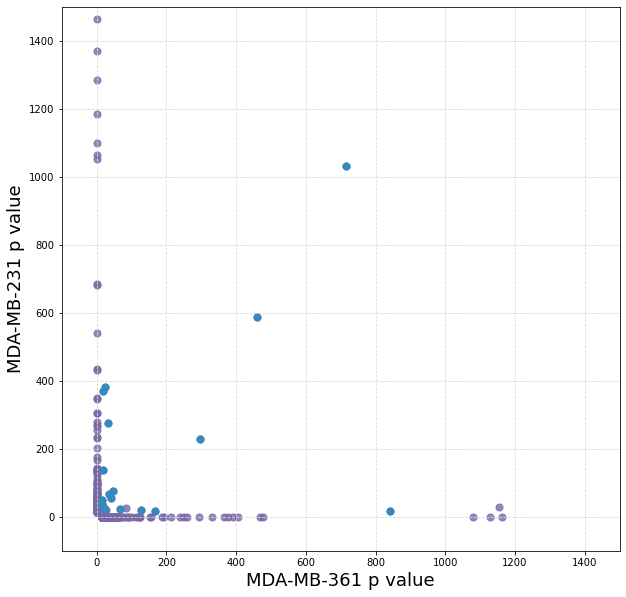

In [18]:
#Plot
fig, ax = plt.subplots(figsize= (10,10))

ax.set_ylabel('MDA-MB-231 p value', fontsize=18)
ax.set_xlabel('MDA-MB-361 p value', fontsize=18)
ax.grid(ls='--', color='#D8D8D8')
ax.set_xlim(-100,1500)
ax.set_ylim(-100,1500)
ax = plt.scatter(-np.array(x), -np.array(y), s=50, c='#7A68A6', alpha=0.8)
ax = plt.scatter(-np.array(px), -np.array(py), s=50, c='#348ABD')
plt.savefig('./figures/cell_line_local_pval_scatter.pdf')

## Cell line local hit table 
___

In [9]:
MB361_local_freq = collections.Counter(MB361_local_hits['gene_names'])
MB231_local_freq = collections.Counter(MB231_local_hits['gene_names'])

In [11]:
for i in set(MB361_local_freq.keys()).intersection(set(MB231_local_freq.keys())):
    print(i)
    print(MB361_local_hits[MB361_local_hits['gene_names'] == i]['region'].values)
    print(MB231_local_hits[MB231_local_hits['gene_names'] == i]['region'].values)

RNH1
['chr11:506716-507216']
['chr11:506716-507216']
RP11-139K1.2
['chr10:112963748-112964248']
['chr10:113326422-113326922']
TUBG2
['chr17:42658996-42659496']
['chr17:42658996-42659496']
BCKDHB
['chr6:80106743-80107243' 'chr6:80106304-80106804']
['chr6:80106304-80106804' 'chr6:80106743-80107243']
PPARA
['chr22:45688631-45689131']
['chr22:46159668-46160168']
IFITM3
['chr11:320278-320778']
['chr11:320278-320778']
HIST1H2AM
['chr6:26568556-26569083' 'chr6:27177680-27178180']
['chr6:28922148-28922648']
FBXO32
['chr8:123537580-123538080' 'chr8:123548191-123548691'
 'chr8:123241141-123241641']
['chr8:123632927-123633427' 'chr8:123680918-123681418']
LGMN
['chr14:92748396-92748896']
['chr14:92748396-92748896']
BLOC1S3
['chr19:45443419-45443919']
['chr19:43785159-43785659']
BTBD6
['chr14:105248313-105248813']
['chr14:105248313-105248813']
C19orf60
['chr19:18588521-18589021']
['chr19:18588521-18589021']
HCN3
['chr1:154955959-154956459']
['chr1:155323052-155323552']
RPS6KL1
['chr14:73609755-7361